# Weekly Meeting 8

* Intersection of values at different hops for the entities in the infobox graph.
* (A bit of) Automatic candidate generation.
* Procrastination: experimenting with RotatE for learning graph embeddings of infobox and categories.

In [106]:
from pyvis import network as net
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
%matplotlib notebook
import itertools
import pickle as pkl
import networkx as nx
import numpy as np
import torch
from networkx.algorithms.shortest_paths import shortest_path as get_shortest_path
import sys
sys.path.insert(0, "../")
import modeling

In [107]:
def graph_visualization(graph):
    g = net.Network(notebook=True, height="500px", width="900px", directed=True)
    g.show_buttons(filter_=['physics'])
    g.from_nx(graph)
    return g

def get_tesa_information(path):
    with open(path, "rb") as fr:
        modeling_task = pkl.load(fr)
    
    entities = []
    aggregations = []
    gold_standards = []
    types = []
    
    # modeling_task.test_loader: 
    for ranking_task in list(itertools.chain(*[modeling_task.train_loader,
                                               modeling_task.valid_loader,
                                               modeling_task.test_loader])):
        aggregations.append([])
        gold_standards.append([])
        entities.append(ranking_task[0][0]["entities"])
        types.append(ranking_task[0][0]["entities_type"])
        for (inp, trg) in ranking_task:
            gold_standards[-1].extend(trg)
            aggregations[-1].extend(inp["choices"])
    
    return entities, aggregations, gold_standards, types

In [108]:
path = "./context-dependent-same-type_50-25-25_rs24_bs4_cf-v0_tf-v2.pkl"
aggregatable_entities, candidates, gold_standards, types = get_tesa_information(path)

## Intersections in the infobox graph

In [109]:
with open("./knowledge_graphs/infobox_graph_depth-3.pkl", "rb") as fr:
    infobox_graph = pkl.load(fr)

In [110]:
def get_hops(entity, infobox_graph, hops=1):
    hops_map = {0: set([entity])}
    for i in range(1, hops + 1):
        hops_map[i] = set([])
        if entity not in infobox_graph:
            continue
        for node in hops_map[i-1]:
            successors = set([successor for successor in infobox_graph.successors(node)
                              if successor and "WP:" not in successor])
            hops_map[i] = hops_map[i].union(successors)
    
    if entity in infobox_graph:
        hops_map["all"] = set.union(*list(hops_map.values()))
    else:
        hops_map["all"] = hops_map[0]
    return hops_map

In [111]:
def get_depth_intersection(intersection, entities_hops):
    depth_intersection = []
    for node in intersection:
        sum_depths = 0
        for entity in entities_hops:
            for depth in entities_hops[entity]:
                if depth != "all" and node in entities_hops[entity][depth]:
                    sum_depths += depth
                    break
        depth_intersection.append((node, sum_depths))
    return sorted(list(set(depth_intersection)), key=lambda x: x[1])
                        
    
def infobox_value_intersection(aggregatable_entities, infobox_graph, hops=1, topk=10):
    """
    Given a tuple of entities
        1) Computes the successors of each entity until a maximum depth *hops*.
        2) Intersects all successors (common successors)
        3) Sorts the common successors by sum of distances to the entities and pick the $k$ lowest.
    """
    
    intersections = {}
    
    for entities in aggregatable_entities:
        # 1)
        entities_hops = {entity: get_hops(entity, infobox_graph, hops) for entity in entities}
        # 2)
        all_hops = [entities_hops[entity]["all"] for entity in entities_hops]
        intersection = set.intersection(*all_hops)
        # 3)
        depth_intersections = get_depth_intersection(intersection, entities_hops)[:topk]

        intersections[tuple(entities)] = [k for k, _ in depth_intersections]
    
    return intersections
    
    
def make_analysis(intersections):
    statistics = {"empty_intersections": 0}
    statistics["empty_intersections"] = len([k for k in list(intersections.values()) if not k]) \
                                        / len(intersections)
    return statistics

*Percentages over unique tuples of entities from train+valid+test*.
<br>*Avg lengths of non-empty intersections*.

| Statistic  | 1-hops | 2-hops | 3-hops | 4-hops |
|---| --- | --- | --- | --- |
|Empty intersections | 61.68% | 33.38% | 29.94% | 29.42% |
|Avg len intersections | 3.29 | 56.49 | 595.00 | 3656.45 |

### Analysis 1-hop

In [112]:
intersections_1 = infobox_value_intersection(aggregatable_entities, infobox_graph, hops=1, topk=999)

The intersections seem informative in many cases. Some examples:

* **('Romano Prodi', 'Silvio Berlusconi')** $\rightarrow$ "Prime minister of Italy", "Kingdom of Italy". They are linked by office, birth place and successors/predecessors in the office.


* **('Billy Wagner', 'Mariano Rivera')** $\rightarrow$ Major League baseball All-Star, 2008 MLB All-Star Game. They are linked by highlights and statistics.


* **('Viktor A. Yushchenko', 'Viktor F. Yanukovich')** $\rightarrow$ Prime Minister of Ukraine, People's Deputy of Ukraine, Ukraininan Soviet Socialist Republic. They are linked by office, birth place and successors/predecessors in the office.


* **('Vermont', 'Virginia')** $\rightarrow$ Eastern Daylight Time, Eastern Time Zone. They are linked by timezone and governor/senators.


* **('Czech Republic', 'Russia')** $\rightarrow$ Republic, Russian Language, Christian denominations. They are linked by religion, government type and languages.

In [113]:
# Good examples (1-hops) #
entities = [('Romano Prodi', 'Silvio Berlusconi'),
            ('Billy Wagner', 'Mariano Rivera'),        
            ('Vermont', 'Virginia'),
            ('Czech Republic', 'Russia'),
            ('Viktor A. Yushchenko', 'Viktor F. Yanukovich')]

subgraph = infobox_graph.subgraph(list(itertools.chain(*[list(ent) + 
                                                          intersections_1[ent] 
                                                          for ent in entities])))

graph_visualization(subgraph).show("_.html")

But there are many entity tuples without intersections.

In [114]:
for key in intersections_1:
    print("%s\n%s\n" % (str(key), str(intersections_1[key])) + "-" * 50 + "\n")

('Abdul Rahman', 'Hamid Karzai')
[]
--------------------------------------------------

('David H. Safavian', 'Jack Abramoff')
[]
--------------------------------------------------

('J. Dennis Hastert', 'Mark Foley')
['Republican Party (United States)']
--------------------------------------------------

('Katie Flynn', 'Stanley Rabinowitz')
[]
--------------------------------------------------

('Israel', 'Lebanon')
['International Monetary Fund']
--------------------------------------------------

('Billy Crudup', 'Duncan Sheik', 'John Gallagher', 'Julie White', 'Tom Stoppard')
[]
--------------------------------------------------

('Doug Wright', 'Scott Frankel')
[]
--------------------------------------------------

('Boston Scientific Corp.', 'Johnson & Johnson Inc.')
['Chief executive officer', 'Public company']
--------------------------------------------------

('California', 'Florida', 'Iowa', 'New Jersey', 'South Carolina')
['United States Geological Survey']
---------------

I have generated a subgraph, with the entities and their 1-hop intersections, to compare it with the full infobox graph:

In [115]:
subgraph = nx.DiGraph(infobox_graph.subgraph(list(itertools.chain(*[list(ent) + 
                                                          intersections_1[tuple(ent)] 
                                                          for ent in aggregatable_entities]))))

print("Infobox graph |V|=%d | Preprocessed graph |V|=%d" % (len(infobox_graph.nodes), len(subgraph.nodes)))
print("Infobox graph |E|=%d | Preprocessed graph |E|=%d" % (len(infobox_graph.edges), len(subgraph.edges)))
print("Number of weakly connected components:", len(list(nx.weakly_connected_components(subgraph))))

#graph_visualization(subgraph).show("_.html")

Infobox graph |V|=97394 | Preprocessed graph |V|=1933
Infobox graph |E|=234420 | Preprocessed graph |E|=6799
Number of weakly connected components: 253


*The reduced infobox considers train+dev+test*

| Graph | \|V\| | \|E\| | WCC | 
|---| --- | --- | --- |
| Infobox | 97394 | 234420 | 4 |
| Reduced infobox (1-hop) | 1933 | 6799 | 253 |

The main WCC of the reduced infobox (1-hop) contains 1678 nodes, the remaining nodes are entities without intersections at the 1-hop.

### Analysis 2-hops

In [116]:
intersections_2 = infobox_value_intersection(aggregatable_entities, infobox_graph, hops=2, topk=10)

In this case, the number of WCC of the subgraph is reduced, as new intersections among the entities in the tuples arise at 2-hops.

In [117]:
subgraph = nx.DiGraph(infobox_graph.subgraph(list(itertools.chain(*[list(ent) + 
                                                          intersections_2[tuple(ent)] 
                                                          for ent in aggregatable_entities]))))

subgraph = build_connected_graph(subgraph, infobox_graph, intersections_2)

print("Infobox graph |V|=%d | Preprocessed graph |V|=%d" % (len(infobox_graph.nodes), len(subgraph.nodes)))
print("Infobox graph |E|=%d | Preprocessed graph |E|=%d" % (len(infobox_graph.edges), len(subgraph.edges)))
print("Number of weakly connected components:", nx.number_weakly_connected_components(subgraph))

#graph_visualization(subgraph).show("_.html")

NameError: name 'build_connected_graph' is not defined

| Graph | \|V\| | \|E\| | WCC | 
|---| --- | --- | --- |
| Infobox | 97394 | 234420 | 4 |
| Reduced infobox (1-hop) | 811 | 2458 | 253 |
| Reduced infobox (2-hops k=all) | 12200 | 53327 | 116 |
| Reduced infobox (2-hops k=10) | 3262 | 13733 | 173 |

Some entities, that haven't got intersections in the 1-hop, are intersected in 2-hops with "useful" information:

**('Belarus', 'Europe', 'Poland', 'Russia', 'Slovakia', 'Ukraine')** $\rightarrow$ Russian language, Polish language, Ukrainians, Warsaw Pact, Balto-Slavic languages.

**('Iran', 'Israel')** $\rightarrow$ Kurdish language, Persian language, United Nations, Arabic, Presidential system, Armenian language, Unitary state.

**('Nanni Moretti', 'Silvio Berlusconi')** $\rightarrow$ Prime Minister of Italy, Italy,  Italian regions, Italian language, Rome, Sardinian language, Comune.

**('Francois Bayrou', 'Nicolas Sarkozy', 'Segolene Royal')** $\rightarrow$ Budget Ministers of France, Paris, Mayor (France), The Republicans (France), Minister of the Interior (France)

**('Google Inc.', 'Microsoft Corp.')** $\rightarrow$ Computer hardware, Internet, Cloud computing

**('London Stock Exchange', 'Nasdaq Stock Market')** $\rightarrow$ Stock exchange

**('Journal of Urology', 'Mayo Clinic')** $\rightarrow$ United States, Medicine, surgery


But others:

**('Elizabeth Kolbert', 'Tim Flannery')** $\rightarrow$ Latin, Urban area ("Latin" comes from the language of the motto of the alma matter of both entities)

**('Hillary Rodham Clinton', 'Saddam Hussein')** $\rightarrow$ Republican Party (United States), Bachelor of Arts, George H. W. Bush, English language, Florida, Mayor–council government, Colin Powell, sovereign states.


**('Kosovo', 'Russia', 'Serbia')** $\rightarrow$ International Monetary Fund (very general)

**('China', 'Japan', 'South Korea')** $\rightarrow$ Unitary state, United Nations Development Programme (very general)

**('Kuwait', 'Oman', 'United Arab Emirates')** $\rightarrow$ United Nations Development Programme (very general)

In [118]:
for key in intersections_1:
    if not intersections_1[key] and intersections_2[key]:
        print("%s\n%s\n" % (str(key), str(intersections_2[key])) + "-" * 50 + "\n")

('Abdul Rahman', 'Hamid Karzai')
['Sunni Islam', 'Islam']
--------------------------------------------------

('Afghanistan', 'Iraq')
['Afghanistan', 'Unitary state', 'First language', 'Persian language', 'Dari language', 'Second language', 'Lower Saxony', 'Hejaz', 'Western Iranian languages', 'Iranian languages']
--------------------------------------------------

('Europe', 'Iran', 'Russia')
['Russia', 'Russian language', 'Ukraine', 'English language', 'United Nations', 'Cyrillic script', 'Capital city', ' sovereign states', 'Russian Braille']
--------------------------------------------------

('Central African Republic', 'Chad', 'Darfur', 'Sudan')
['Sudan', 'Arabic language', 'South Sudan', 'Arabs', 'Chadian Arabic', 'United Nations', 'Sudanese Arabic']
--------------------------------------------------

('David H. Petraeus', 'Harry Reid', 'Peter Pace')
['Bronze Star Medal', 'New York (state)', 'Vietnam War', 'Chuck Schumer', 'Democratic Party (United States)', 'Kirsten Gillibrand'

## Experimentation

| System | MAP | R@10 | MRR |
| -- |  -- | -- | -- |
| BCE | 83.07 | 93.02 | 93.90 |
| ABCE (CAT k=6) | 83.19 | 93.25  | 94.39 |
| IBCE (1-hop, k=all) | 83.03 | 93.17 | 93.95 |
| IBCE (2-hops, k=100) | 82.57 | 92.14  | 93.38 |
| IBCE (2-hops, k=10) | 83.11 | 92.87 | 94.31 |
| AIBCE (1-hop, k=all) | **83.25** | **93.40** | **94.55** |
| AIBCE (2-hops, k=10) | 83.00 | 92.81 | 94.50 |

### Automatic candidate generation.

#### Overlapping among gold standards and ancestors

I did this with the 6 lowest common ancestors, but, how many ancestors should we use?

In [119]:
with open("./knowledge_graphs/6_lowest_common_ancestors_graph.pkl", "rb") as fr:
    ancestors = pkl.load(fr)

In [120]:
stop_words = set(stopwords.words('english')) 
def overlap(golds, lca):
    
    def _overlap(lca, golds):
        return len(lca.intersection(golds)) / len(golds)
    
    def _filter(lst):
        # Remove stopwords #
        lst = [" ".join([word for word in l.split() if word not in stop_words]) for l in lst]
        # Lowercase #
        lst = [l.lower() for l in lst]
        return lst
    
    golds = set(_filter(golds))
    lca = set(_filter(lca))

    return {"aggregation level": _overlap(lca, golds),
            "word level": _overlap(set(itertools.chain(*[a.split() for a in lca])),
                                   set(itertools.chain(*[g.split() for g in golds])))}

In [121]:
avg_statistics = {"aggregation level": 0.,
                  "word level": 0.}
for i, entities in enumerate(aggregatable_entities):
    lca = ancestors[tuple(entities)]
    cands = candidates[i]
    labels = [bool(gs.item()) for gs in gold_standards[i]]
    golds = list(itertools.compress(cands, labels))
    overl = overlap(golds, lca)
    avg_statistics["aggregation level"] += overl["aggregation level"]
    avg_statistics["word level"] += overl["word level"]
    print("Entities:", entities)
    print("Gold Standards:", golds)
    print("Ancestors:", lca)
    print("Overlap Measures:", overl)
    print("-" * 50 + "\n"*3)
    
avg_statistics["aggregation level"] /= i
avg_statistics["word level"] /= i
print(avg_statistics)

Entities: ['Abdul Rahman', 'Hamid Karzai']
Gold Standards: ['men', 'afghan politicians', 'afghans']
Ancestors: ['European masculine given names', 'Given names', 'Iranian ethnic groups', 'Iranic people', 'Masculine given names', 'Pakistani social culture']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------



Entities: ['David H. Safavian', 'Jack Abramoff']
Gold Standards: ['lobbyists', 'american lobyists', 'americans']
Ancestors: ['American lawyers', 'American people', 'Jack Abramoff scandals', 'Lawyers', 'People associated with the Jack Abramoff scandals', 'Republicans (United States)']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.25}
--------------------------------------------------



Entities: ['J. Dennis Hastert', 'Mark Foley']
Gold Standards: ['former representatives', 'former american politicians', 'former politicians']
Ancestors: ['Members of state lower houses in the United States', 'Members of th

Entities: ['Africa', 'Canada', 'France', 'Germany', 'Italy', 'Japan']
Gold Standards: ['destinations', 'various regions', 'areas of the world', 'geographic locales']
Ancestors: ['Administrative territorial entities', 'Countries', 'G20 nations', 'G7 nations', 'Group of Eight nations', 'Member states of the United Nations']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------



Entities: ['Dick Cheney', 'Saddam Hussein']
Gold Standards: ['leaders', 'world leaders', 'politicians']
Ancestors: ['American people', 'Iraqi people', 'Male writers', 'People from Wyoming', 'Presidents', 'Vice presidents']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------



Entities: ['James Glicker', 'W. Gar Richlin']
Gold Standards: ['men', 'audiophiles']
Ancestors: []
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------





Entities: ['Aleksandr G. Lukashenko', 'Aleksandr Milinkevich']
Gold Standards: ['men', 'aleksandrs']
Ancestors: ['Belarusian people', 'Belarusian politicians', 'Districts of Lower Saxony', 'Ghanaian people', 'Municipalities in the Community of Madrid', 'Universities and colleges in Arkansas']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------



Entities: ['Ehud Olmert', 'Mahmoud Abbas']
Gold Standards: ['politicians', 'men']
Ancestors: ['Government ministers', 'Heads of government', 'Israeli people', 'Members of unicameral legislatures', 'National legislators', 'Prime Ministers']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------



Entities: ['Concetta Tomei', 'Vanessa Aspillaga']
Gold Standards: ['entertainers', 'performers', 'actresses']
Ancestors: []
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
------------------------------------------

Entities: ['Cory Booker', 'Ronald Rice']
Gold Standards: ['american politicians', 'democrats']
Ancestors: ['African-American people in New Jersey politics', 'Democrats (United States)', 'New Jersey Democratic State Committee', 'New Jersey Democrats', 'New Jersey politicians', 'Politicians from Newark, New Jersey']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.6666666666666666}
--------------------------------------------------



Entities: ['Veselin Topalov', 'Vladimir Kramnik']
Gold Standards: ['competitors', 'chess grandmasters']
Ancestors: ['Chess Olympiad competitors', 'Chess grandmasters', 'Chess players', 'Chess titles', 'World Youth Chess Champions', 'World chess champions']
Overlap Measures: {'aggregation level': 0.5, 'word level': 1.0}
--------------------------------------------------



Entities: ['Belarus', 'Czech Republic', 'Germany', 'Hungary', 'Russia', 'Ukraine']
Gold Standards: ['eastern european countries', 'nations', 'european countries']
Ancestors: ['

Entities: ['Iraq', 'United States']
Gold Standards: ['nations', 'countries']
Ancestors: ['Countries', 'Federal countries', 'Federal republics', 'Member states of the United Nations', 'Republics', 'United Nations']
Overlap Measures: {'aggregation level': 0.5, 'word level': 1.0}
--------------------------------------------------



Entities: ['Kassoum Fofana', 'Osman Adam']
Gold Standards: ['muslim men', 'devoted muslims']
Ancestors: []
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------



Entities: ['Barry Diller', 'Frank Gehry']
Gold Standards: ['american influencers', 'men with an interest in architecture', 'americans']
Ancestors: ['American Jews', 'American people', 'Jews', 'People from California', 'People from Los Angeles', 'People in technology']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.16666666666666666}
--------------------------------------------------



Entities: ['Andrew Young', 'Gregory D. D

Entities: ['James Ingo Freed', 'Richard Rogers']
Gold Standards: ['designers', 'architects']
Ancestors: ['American architects', 'Architects', 'British architects', 'Buildings and structures', 'Modernist architects', 'Modernist architecture']
Overlap Measures: {'aggregation level': 0.5, 'word level': 0.5}
--------------------------------------------------



Entities: ['Fatah', 'Hamas']
Gold Standards: ['muslim political organizations', 'palestinian entities', 'political powers']
Ancestors: ['National liberation movements', 'Organisations designated as terrorist', 'Organizations designated as terrorist', 'Palestinian nationalist parties', 'Palestinian political parties', 'Resistance movements']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.5}
--------------------------------------------------



Entities: ['Ethan Stiefel', 'Johan Kobborg']
Gold Standards: ['ballet dancers', 'dancers']
Ancestors: ['Cities in British Columbia', 'Cities in Iowa', 'Comarcas of Spain', 'Male b

Entities: ['Martha Kumler', 'Raymond Davis Jr.']
Gold Standards: ['scientists', 'family members']
Ancestors: []
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------



Entities: ['Bill T. Jones', 'Duncan Sheik', 'John Gallagher', 'Steven Sater']
Gold Standards: ['artists', 'entertainers']
Ancestors: []
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------



Entities: ['Google Inc.', 'Palo Alto Research Center', 'Powerset']
Gold Standards: ['internet companies', 'tech companies', 'california corporations', 'silicon valley organizations', 'research companies']
Ancestors: ['Artificial intelligence', 'Companies based in California', 'Companies based in the San Francisco Bay Area', 'Companies of the United States', 'Cyberspace', 'Organizations based in the United States']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.3333333333333333}
-------------------

Entities: ['Afghanistan', 'Pakistan']
Gold Standards: ['islamic republics', 'countries', 'neighboring countries']
Ancestors: ['Countries in Asia', 'Islamic republics', 'Member states of the Organisation of Islamic Cooperation', 'Member states of the South Asian Association for Regional Cooperation', 'Member states of the United Nations', 'South Asian countries']
Overlap Measures: {'aggregation level': 0.3333333333333333, 'word level': 0.75}
--------------------------------------------------



Entities: ['Israel', 'Jerusalem']
Gold Standards: ['middle eastern locales', 'nations', 'israeli territories']
Ancestors: ['Countries in Asia', 'Israel', 'Land of Israel', 'Levant', 'Regions of Asia', 'Use American English from July 2020']
Overlap Measures: {'aggregation level': 0.0, 'word level': 0.0}
--------------------------------------------------



Entities: ['Bill T. Jones', 'Billy Crudup', 'Frank Langella', "Jack O'Brien", 'Julie White', 'Tom Stoppard']
Gold Standards: ['entertainers', '

The overlapping is very small and it's not clear how to compute it. 
There are many cases where the overlap measure at aggregation level is 0, but the ancestors seem reasonable (some of them more than others):

['Connecticut', 'New Jersey']
['Israel', 'Lebanon']
['Fatah', 'Hamas']
['Massimiliano Gioni', 'Maurizio Cattelan']
['John Lewis', 'Shirley Clarke Franklin']
['China', 'North Korea']
['Harry Carson', 'John Madden', 'Rayfield Wright', 'Troy Aikman']
['Aeroflot', 'Alitalia']
['Bill Clinton', 'Lauren Bush']
['Ethiopia', 'Kenya', 'Somalia', 'Tanzania']
['Mexico', 'United States']
['John C. Malone', 'Rupert Murdoch']


Some kind of alignment?:

**('John C. Malone', 'Rupert Murdoch') (aggregation overlap=0.0)**
<br>
media mogul    | American mass media owners, American media company founders
<br>businessmen    | American chairmen of corporations, American chief executives
<br> $\emptyset$  | American libertarians, American billionaires




Objetivo: "narrow down the set of candidates in test for entities we have not seen during training."
"what is the overlap between gold standards and the ancestors? ... if we get somewhat reasonable numbers here, that is a very good sign, because this model does not use oracle gold standards in the candidate list". But not, the overlapping between them is very small and it is not clear how to compute it:

Entities: ['John C. Malone', 'Rupert Murdoch']
<br>Gold Standards: ['media moguls', 'businessmen']
<br>Ancestors: ['American billionaires', 'American chairmen of corporations', 'American chief executives', 'American libertarians', 'American mass media owners', 'American media company founders']

So, we can't rely only on the ancestors for narrowing the set of candidates ([ancestors, negatives]). Instead, we combine them with the gold standards during training. Also, negative candidates are sampled from the graphs to get harder negatives.


### Appendix

### Some experimentation with RotatE

In [14]:
infobox_path = "./GraphEmbeddings/RotatEInfobox/"
category_path = "./GraphEmbeddings/RotatECategory/"

infobox_entities = {}
category_entities = {}
infobox_relations = {}
category_relations = {}

with open(infobox_path + "data/entities.dict", "r") as fr:
    for line in fr.readlines():
        idx, ent = line.strip().split("\t")
        infobox_entities[ent] = idx

with open(infobox_path + "data/relations.dict", "r") as fr:
    for line in fr.readlines():
        idx, rlt = line.strip().split("\t")
        infobox_relations[rlt] = idx

with open(infobox_path + "model/entity_embedding.npy", "rb") as fr:
    infobox_entity_embeddings = np.load(fr)
    
with open(infobox_path + "model/relation_embedding.npy", "rb") as fr:
    infobox_relation_embeddings = np.load(fr)
    
with open(category_path + "data/entities.dict", "r") as fr:
    for line in fr.readlines():
        idx, ent = line.strip().split("\t")
        category_entities[ent] = idx
        
with open(category_path + "data/relations.dict", "r") as fr:
    for line in fr.readlines():
        idx, rlt = line.strip().split("\t")
        category_relations[rlt] = idx

with open(category_path + "model/entity_embedding.npy", "rb") as fr:
    category_entity_embeddings = np.load(fr)
    
with open(category_path + "model/relation_embedding.npy", "rb") as fr:
    category_relation_embeddings = np.load(fr)

### Test score triples (link prediction)

In [15]:
gamma = 24.0
hidden_dim = 512
epsilon = 2.0

embedding_range = torch.nn.Parameter(torch.Tensor([(gamma + epsilon) / hidden_dim]), 
                                     requires_grad=False)

# Modified from: https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding/blob/master/codes/model.py
def RotatE_score(eh, er, et, mode="single"):
    pi = 3.14159265358979323846

    re_head, im_head = torch.chunk(eh, 2, dim=0)
    re_tail, im_tail = torch.chunk(et, 2, dim=0)

    # Make phases of relations uniformly distributed in [-pi, pi]

    phase_relation = er/(embedding_range.item()/pi)

    re_relation = torch.cos(phase_relation)
    im_relation = torch.sin(phase_relation)

    if mode == 'head-batch':
        re_score = re_relation * re_tail + im_relation * im_tail
        im_score = re_relation * im_tail - im_relation * re_tail
        re_score = re_score - re_head
        im_score = im_score - im_head
    else:
        re_score = re_head * re_relation - im_head * im_relation
        im_score = re_head * im_relation + im_head * re_relation
        re_score = re_score - re_tail
        im_score = im_score - im_tail

    score = torch.stack([re_score, im_score], dim = 0)
    score = score.norm(dim = 0)

    score = gamma - score.sum(dim = 0)
    return score

In [16]:
def get_score(h, r, t, entity_embeddings, relation_embeddings, entities, relations):
    return RotatE_score(torch.from_numpy(entity_embeddings[int(entities[h])]),
       torch.from_numpy(relation_embeddings[int(relations[r])]),
       torch.from_numpy(entity_embeddings[int(entities[t])]))

#### Infobox

In [17]:
get_score("Microsoft", "industry", "Computer hardware",
          infobox_entity_embeddings, infobox_relation_embeddings,
          infobox_entities, infobox_relations)

tensor(5.5342)

In [18]:
get_score("Microsoft", "industry", "Software development",
          infobox_entity_embeddings, infobox_relation_embeddings,
          infobox_entities, infobox_relations)

tensor(10.6658)

But...

In [19]:
get_score("Microsoft", "industry", "Computer software", 
          infobox_entity_embeddings, infobox_relation_embeddings,
          infobox_entities, infobox_relations)

tensor(-3.9938)

In [20]:
bsc = float("-inf")
b = None
h = "Windows"
r = "programmed in"

for t in infobox_entities:
    sc = get_score(h, r, t, infobox_entity_embeddings,
                   infobox_relation_embeddings,
                   infobox_entities, infobox_relations)
    if sc > bsc:
        bsc = sc
        b = t
        print(bsc, b)

print(h, r, "[" + b + "]")

tensor(-11.7846) 40 11 N 44 31 E
tensor(-8.2768) Edmund Burke
tensor(-7.5675) Federal Information Processing Standards
tensor(-7.2332) Madonna (entertainer)
tensor(-3.8116) Java (programming language)
tensor(-2.4235) assembly language
tensor(-2.1765) C++
Windows programmed in [C++]


#### Category

In [21]:
get_score("Microsoft Corp.", "is a", "Technology companies of the United States",
          category_entity_embeddings, category_relation_embeddings,
          category_entities, category_relations)

tensor(4.7820)

In [22]:
get_score("Microsoft Corp.", "is a", "Technology companies",
          category_entity_embeddings, category_relation_embeddings,
          category_entities, category_relations)

tensor(-6.1577)

In [23]:
bsc = float("-inf")
b = None
h = "Iran"
r = "is a"

for t in category_entities:
    sc = get_score(h, r, t, category_entity_embeddings,
                   category_relation_embeddings,
                   category_entities, category_relations)
    if sc > 0:
        if sc > bsc:
            bsc = sc
            b = t
        print(t)

print(h, r, "[" + b + "]")

Former monarchies of Western Asia
Places in the Deuterocanonical books
States and territories established in 1979
Iranian Plateau
Iranian countries and territories
Member states of OPEC
1979 establishments in Iran
Kurdish-speaking countries and territories
Use American English from February 2017
Countries in Asia
Western Asian countries
G15 nations
Islamic republics
Middle Eastern countries
Near Eastern countries
Member states of the Organisation of Islamic Cooperation
Persian-speaking countries and territories
Member states of the United Nations
Azerbaijani-speaking countries and territories
Iran is a [Former monarchies of Western Asia]


### TSNE projections of the entity embeddings (only entities of TESA)

#### Infobox

<IPython.core.display.Javascript object>


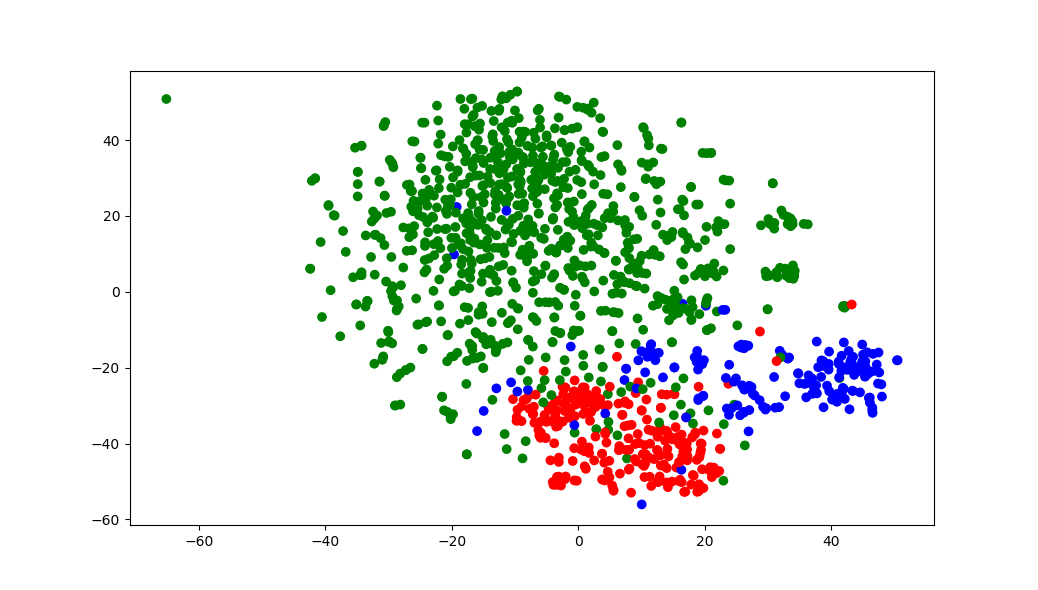

In [26]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

colors = {"location": "r", "org": "b", "person": "g"}

tesa_entities = []
entity_colors = []
for i, entity_tuple in enumerate(aggregatable_entities):
    tesa_entities += [entity for entity in entity_tuple if entity in infobox_entities]
    entity_colors += [colors[types[i]] for entity in entity_tuple if entity in infobox_entities]

tesa_entities, entity_colors = zip(*set(zip(tesa_entities, entity_colors)))

tesa_entities = [ent for ent in tesa_entities if ent in infobox_entities]                 
tesa_entity_embeddings = np.array([infobox_entity_embeddings[int(infobox_entities[ent])] 
                                   for ent in tesa_entities])

projected_embeddings = TSNE(n_components=2).fit_transform(tesa_entity_embeddings)

fig, ax = plt.subplots()
x, y = zip(*projected_embeddings)

ax.scatter(x, y, color=entity_colors)

In general the clusters seem very interesting. The cluster of locations is bounded by organizations like universities, institutional organizations, newspapers, terrorist organizations and sport teams of some location. The locations are divided in two subclusters, one for american locations and another for african-asian-european regions.
Similar entities of the same type are close together: universities, airlines, french politicians, football players, actors, writers, american/european/asian locations, etc. 

<IPython.core.display.Javascript object>


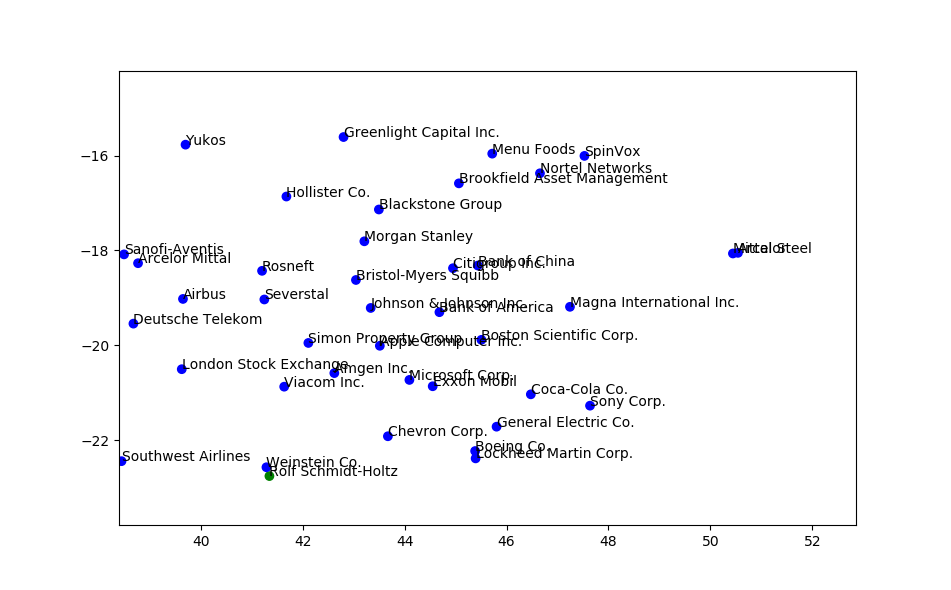

In [27]:
fig, ax = plt.subplots()
x, y = zip(*projected_embeddings)

ax.scatter(x, y, color=entity_colors)
for i, txt in enumerate(tesa_entities):
    ax.annotate(txt, (x[i], y[i]))

Visualization by type:

<IPython.core.display.Javascript object>


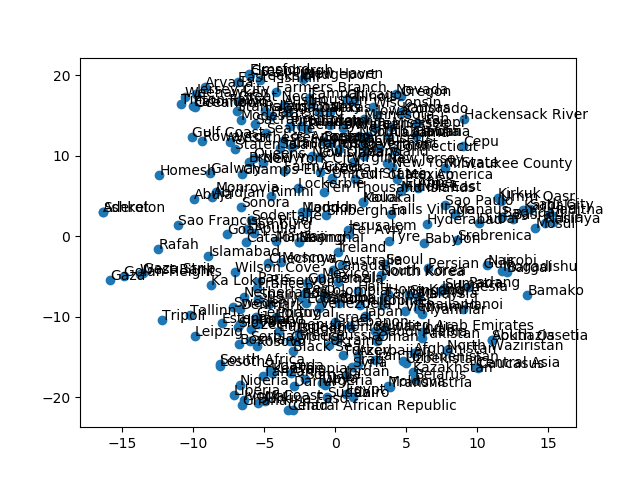

In [79]:
tesa_entities = []
for i, entity_tuple in enumerate(aggregatable_entities):
    if types[i] == "location":
        tesa_entities += [entity for entity in entity_tuple if entity in infobox_entities]
tesa_entities = set(tesa_entities)

tesa_entity_embeddings = np.array([infobox_entity_embeddings[int(infobox_entities[ent])] 
                                   for ent in tesa_entities])

projected_embeddings = TSNE(n_components=2).fit_transform(tesa_entity_embeddings)

fig, ax = plt.subplots()
x, y = zip(*projected_embeddings)

ax.scatter(x, y)

for i, txt in enumerate(tesa_entities):
    ax.annotate(txt, (x[i], y[i]))

#### Category

<IPython.core.display.Javascript object>


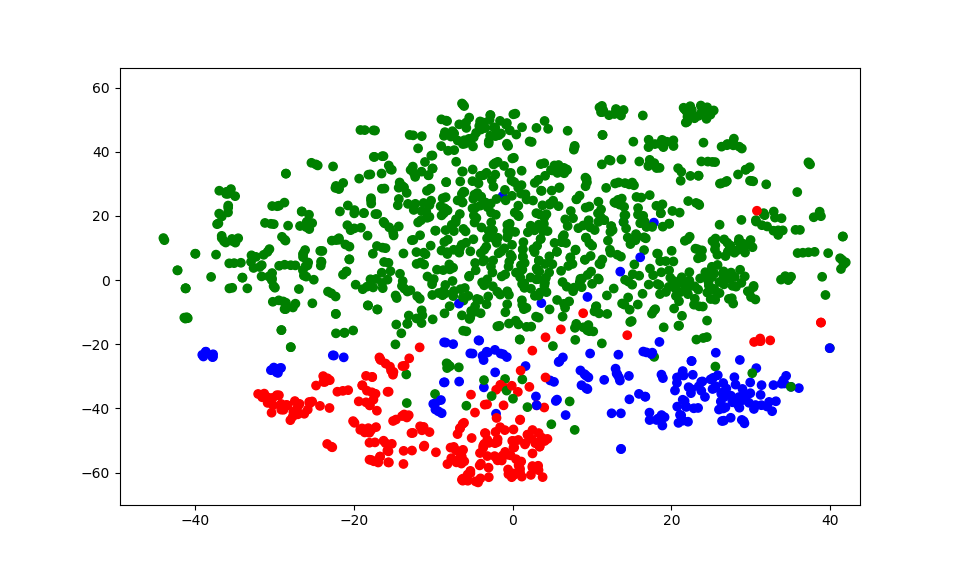

In [28]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

colors = {"location": "r", "org": "b", "person": "g"}

tesa_entities = []
entity_colors = []
for i, entity_tuple in enumerate(aggregatable_entities):
    tesa_entities += [entity for entity in entity_tuple if entity in category_entities]
    entity_colors += [colors[types[i]] for entity in entity_tuple if entity in category_entities]

tesa_entities, entity_colors = zip(*set(zip(tesa_entities, entity_colors)))

tesa_entities = [ent for ent in tesa_entities if ent in category_entities]                 
tesa_entity_embeddings = np.array([category_entity_embeddings[int(category_entities[ent])] 
                                   for ent in tesa_entities])

projected_embeddings = TSNE(n_components=2).fit_transform(tesa_entity_embeddings)

fig, ax = plt.subplots()
x, y = zip(*projected_embeddings)

ax.scatter(x, y, color=entity_colors)

Very similar to the clusters of the infobox graph, but the types seem better separated in this case (person bounds locations in the infobox grahps), also more aggrupations can be identified inside the big clusters (lower intra aggrupation distance and higher inter aggrupation distance). The "belt" of organizations between people and locations seems clearer in this case and the organizations in that belt are the same than in the infobox (universities, institutional organizations, ...)

Some interesting things:

* Captures some "territorial delimitations" (almost overlapped points in the space): (Spain, Portugal), (Italy, France), (Czech Republic, Slovakia), (Greece, Bulgaria), (Kosovo, Serbia), (North Korea, South Korea)

* Cities are better separated from countries (London, Madrid, Paris) and better clusters for some countries: (Brazil, Mexico, ...)

<IPython.core.display.Javascript object>


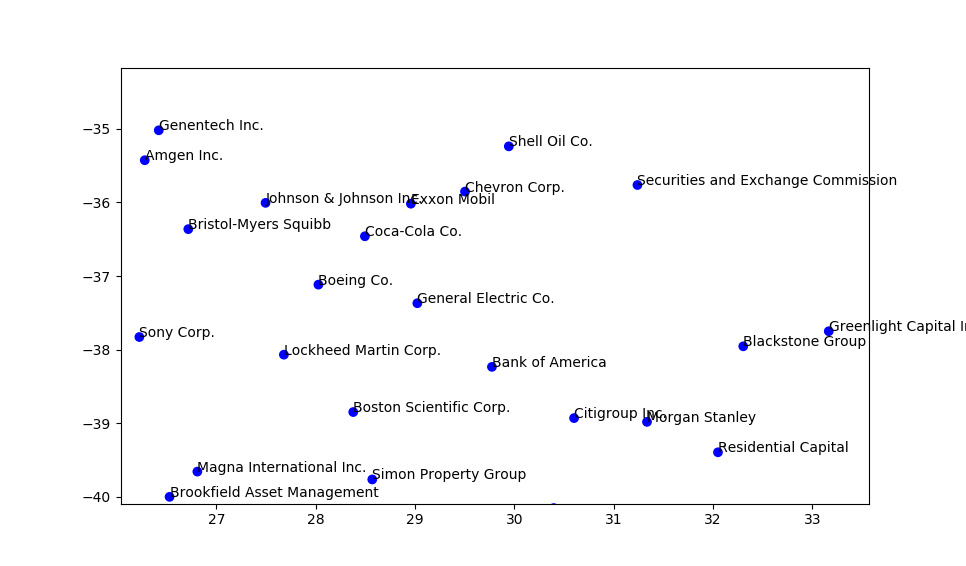

In [31]:
fig, ax = plt.subplots()
x, y = zip(*projected_embeddings)

ax.scatter(x, y, color=entity_colors)
for i, txt in enumerate(tesa_entities):
    ax.annotate(txt, (x[i], y[i]))

Visualization by type:

<IPython.core.display.Javascript object>


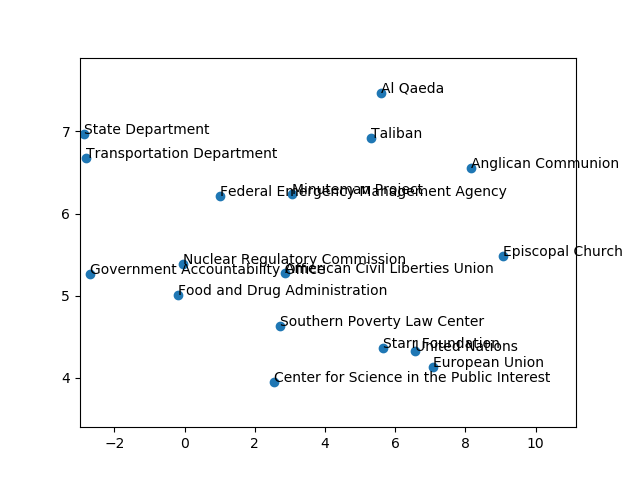

In [32]:
tesa_entities = []
for i, entity_tuple in enumerate(aggregatable_entities):
    if types[i] == "org":
        tesa_entities += [entity for entity in entity_tuple if entity in category_entities]
tesa_entities = set(tesa_entities)

tesa_entity_embeddings = np.array([category_entity_embeddings[int(category_entities[ent])] 
                                   for ent in tesa_entities])

projected_embeddings = TSNE(n_components=2).fit_transform(tesa_entity_embeddings)

fig, ax = plt.subplots()
x, y = zip(*projected_embeddings)

ax.scatter(x, y)

for i, txt in enumerate(tesa_entities):
    ax.annotate(txt, (x[i], y[i]))

Integrating knowledge graph embeddings in pre-trained language models: https://arxiv.org/pdf/1912.00147.pdf

ERNIE: https://arxiv.org/pdf/1904.09223.pdf